**“Benchmark Dataset for Mid-Price Forecasting of Limit Order Book Data with Machine Learning Methods,”**

The paper extracted normalized data representations of time series data for five stocks from the NASDAQ Nordic stock market over a period of ten consecutive days. This process resulted in a dataset comprising around four million time series samples in total, providing a comprehensive market-wide history spanning ten trading days.

**Dataset:**
[Explore the Dataset](https://etsin.fairdata.fi/dataset/73eb48d7-4dbc-4a10-a52a-da745b47a649)

In [1]:
# initialise spark

from pyspark.sql import SparkSession

spark = (
    SparkSession
    .builder.appName("lob")
    .config("spark.executor.memory", "4g").config("spark.driver.memory", "2g")
    .config("spark.executor.extraJavaOptions", "-XX:+UseG1GC -XX:MaxGCPauseMillis=200")
    .config("spark.driver.extraJavaOptions", "-XX:+UseG1GC -XX:MaxGCPauseMillis=200")
    .getOrCreate()
)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/11/13 16:46:10 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In this dataset, the rows indicate features such as asset price and volume, and the columns indicate timestamps. Typically, we would use the rows to indicate observation-level data per timestamp and use the columns to represent features or attributes. We would need to transpose the dataset.

Also, based on the documentation on the dataset, the first 40 rows carry 10 levels of bid and ask from the order book, along with the volume of each particular price point. We have a total of 40 entries per timestamp since each side (buy and sell) contains 10 price levels, and each level includes two points: price and volume. In other words, the limit order book in a single time snapshot shows up as an array of 40 elements.

In [2]:
# Dataset
from pyspark.sql.functions import col, monotonically_increasing_id, split, trim, udf
from pyspark.sql.types import ArrayType, DoubleType, StringType

train_path = "dataset/BenchmarkDatasets/NoAuction/3.NoAuction_DecPre/NoAuction_DecPre_Training/"
train_file = "Train_Dst_NoAuction_DecPre_CF_7.txt"
benchmark_path = "dataset/output/parquet/"

@udf(ArrayType(StringType()))
def process_values(values):
    # print(type(values[0]))
    return [round(float(v), 3) for v in values.split()]

df = (
    spark.read.text(train_path + train_file)
    .withColumn("id", monotonically_increasing_id())
    .withColumn("values", process_values(col("value")))
)

# Select the necessary columns and extract a subset of the values
subset_df = df.select(
    col("id"),
    col("values")[0].alias("value_1"),
    col("values")[1].alias("value_2"),
    col("values")[2].alias("value_3"),
    col("values")[3].alias("value_4"),
    col("values")[4].alias("value_5")
)

# Show the subset DataFrame
subset_df.show(5, truncate=False)
# Convert to parquet 
# df.write.mode("overwrite").parquet(benchmark_path)

+---+-------+-------+-------+-------+-------+
|id |value_1|value_2|value_3|value_4|value_5|
+---+-------+-------+-------+-------+-------+
|0  |0.262  |0.262  |0.261  |0.261  |0.261  |
|1  |0.004  |0.002  |0.001  |0.003  |0.003  |
|2  |0.261  |0.261  |0.261  |0.261  |0.261  |
|3  |0.003  |0.003  |0.003  |0.003  |0.003  |
|4  |0.262  |0.262  |0.262  |0.262  |0.262  |
+---+-------+-------+-------+-------+-------+
only showing top 5 rows



In [3]:
# Analyse the dataset
# parquet write funky stuff
# analyse_df = spark.read.format("parquet").load(benchmark_path)

In [4]:
from pyspark.sql.functions import size, col, expr

first_pair_df = df.select(
    col("id"),
    col("values")[0].alias("ask_price"),
    col("values")[1].alias("ask_quantity"),
    col("values")[2].alias("bid_price"),
    col("values")[3].alias("bid_quantity")
)

first_pair_df.show(5)
# shape of the data

+---+---------+------------+---------+------------+
| id|ask_price|ask_quantity|bid_price|bid_quantity|
+---+---------+------------+---------+------------+
|  0|    0.262|       0.262|    0.261|       0.261|
|  1|    0.004|       0.002|    0.001|       0.003|
|  2|    0.261|       0.261|    0.261|       0.261|
|  3|    0.003|       0.003|    0.003|       0.003|
|  4|    0.262|       0.262|    0.262|       0.262|
+---+---------+------------+---------+------------+
only showing top 5 rows



In [5]:
df.select(col("values")).count()

149

The first 40 rows contain 10 levels
each level has bid, ask and the respective volume
so each level consists of price volume pair
the first 4 pairs mean the ask_price, ask_volume, bid_price, bid_volume


We are dealing with 5 stocks

In [6]:
df.select(
    col("values")[0].alias("ask_price"),
    col("values")[1].alias("ask_volume"),
    col("values")[2].alias("bid_price"),
    col("values")[3].alias("bid_volume"),
).show(5)

+---------+----------+---------+----------+
|ask_price|ask_volume|bid_price|bid_volume|
+---------+----------+---------+----------+
|    0.262|     0.262|    0.261|     0.261|
|    0.004|     0.002|    0.001|     0.003|
|    0.261|     0.261|    0.261|     0.261|
|    0.003|     0.003|    0.003|     0.003|
|    0.262|     0.262|    0.262|     0.262|
+---------+----------+---------+----------+
only showing top 5 rows



In [7]:
# Create sperate dataframes for each of the 4 points ask_price,ask_volume, bid_price, bid_volume

ask_price_df = df.select(col("id"), col("values")[0].alias("ask_price"))
ask_volume_df = df.select(col("id"), col("values")[1].alias("ask_volume"))
bid_price_df = df.select(col("id"), col("values")[2].alias("bid_price"))
bid_volume_df = df.select(col("id"), (col("values")[3].alias("bid_volume")))

print(
   ask_price_df.columns,
ask_volume_df.columns,
bid_price_df.columns,
bid_volume_df.columns, 
)

['id', 'ask_price'] ['id', 'ask_volume'] ['id', 'bid_price'] ['id', 'bid_volume']


In [13]:
# Join bid and ask price DataFrames
dfPrices = bid_price_df.join(ask_price_df, on="id", how="outer")

# Join bid and ask volume DataFrames
dfVolumes = bid_volume_df.join(ask_volume_df, on="id", how="outer")

In [ ]:
# Bid ask visualisation
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = go.Figure()

for column in dfPrices.columns:
    fig.add_trace(go.Scatter(x=dfPrices.limit(1).select("id").collect(), y=dfPrices.limit(1).select(column).collect(), mode="lines", name=column))

fig.update_layout(
    title='10 price levels of each side of the orderbook',
    xaxis_title="Time snapshot index",
    yaxis_title="Price levels",
    height=500,
    showlegend=True,
)

fig.show()
     

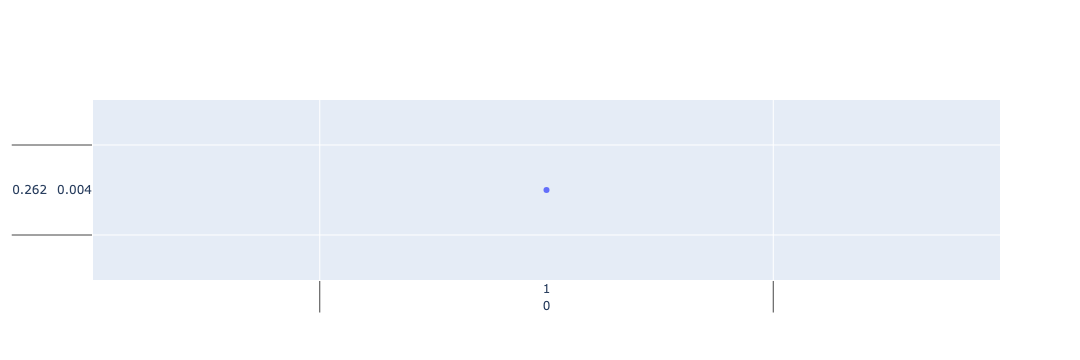

In [12]:
simple_time_series = go.Figure(data=go.Scatter(x=ask_price_df.limit(5).select("id").collect(), y=ask_price_df.limit(5).select("ask_price").collect()))
simple_time_series.show()